In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhasalam","key":"268bdde8d9555bda9480e23abc6c15ca"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

Dataset URL: https://www.kaggle.com/datasets/erhmrai/ecg-image-data
License(s): CC-BY-NC-SA-4.0
 99% 849M/858M [00:09<00:00, 162MB/s]
100% 858M/858M [00:09<00:00, 93.7MB/s]


In [ ]:
!unzip ecg-image-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECG_Image_data/train/V/V1869.png  
  inflating: ECG_Image_data/train/V/V187.png  
  inflating: ECG_Image_data/train/V/V1870.png  
  inflating: ECG_Image_data/train/V/V1871.png  
  inflating: ECG_Image_data/train/V/V1872.png  
  inflating: ECG_Image_data/train/V/V1874.png  
  inflating: ECG_Image_data/train/V/V1877.png  
  inflating: ECG_Image_data/train/V/V1879.png  
  inflating: ECG_Image_data/train/V/V188.png  
  inflating: ECG_Image_data/train/V/V1880.png  
  inflating: ECG_Image_data/train/V/V1881.png  
  inflating: ECG_Image_data/train/V/V1882.png  
  inflating: ECG_Image_data/train/V/V1883.png  
  inflating: ECG_Image_data/train/V/V1884.png  
  inflating: ECG_Image_data/train/V/V1885.png  
  inflating: ECG_Image_data/train/V/V1886.png  
  inflating: ECG_Image_data/train/V/V1887.png  
  inflating: ECG_Image_data/train/V/V1889.png  
  inflating: ECG_Image_data/train/V/V1892.png  
  inflating: ECG_Image_data/train/V/V18

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
IMG_SHAPE = (224, 224)  # Target image size
BATCH_SIZE = 32         # Batch size for training and validation
EPOCHS = 10             # Number of epochs for training

# Path to save the final model to Google Drive
model_save_path = '/content/drive/MyDrive/saved_models/ECG_CNN_model.keras'

In [ ]:
def resize_image(image, label):
    image = tf.image.resize(image, IMG_SHAPE)
    return image, label


In [ ]:
# Load and resize the training data with validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ECG_Image_data/train",
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    seed=123,
    subset="training"
)

# Load the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ECG_Image_data/train",
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    seed=123,
    subset="validation"
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ECG_Image_data/test",
    image_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Apply resizing to training, validation, and test datasets
train_dataset = train_dataset.map(resize_image)
validation_dataset = validation_dataset.map(resize_image)
test_dataset = test_dataset.map(resize_image)


Found 99199 files belonging to 6 classes.
Using 79360 files for training.
Found 99199 files belonging to 6 classes.
Using 19839 files for validation.
Found 24799 files belonging to 6 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# Apply data augmentation to the training dataset
augmented_train_dataset = train_dataset.map(
    lambda image, label: (data_augmentation(image, training=True), label)
)


In [ ]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalize pixel values

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(6, activation='softmax')  # 6 output classes for ECG categories
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

model.save(model_save_path)  # Save in HDF5 format (.h5)
print(f"Model saved to {model_save_path}")


Epoch 1/10
2480/2480 [==============================] - 1119s 451ms/step - loss: 0.1843 - accuracy: 0.9505 - val_loss: 0.1190 - val_accuracy: 0.9926
Epoch 2/10
2480/2480 [==============================] - 1117s 450ms/step - loss: 0.0245 - accuracy: 0.9942 - val_loss: 4.8070e-09 - val_accuracy: 1.0000
Epoch 3/10
2480/2480 [==============================] - 1133s 457ms/step - loss: 0.0190 - accuracy: 0.9970 - val_loss: 1.8027e-11 - val_accuracy: 1.0000
Epoch 4/10
2480/2480 [==============================] - 1104s 445ms/step - loss: 7.7672e-05 - accuracy: 1.0000 - val_loss: 1.2018e-11 - val_accuracy: 1.0000
Epoch 5/10
2480/2480 [==============================] - 1123s 453ms/step - loss: 2.8398e-06 - accuracy: 1.0000 - val_loss: 1.2156e-08 - val_accuracy: 1.0000
Epoch 6/10
2480/2480 [==============================] - 1125s 453ms/step - loss: 0.4949 - accuracy: 0.9374 - val_loss: 0.0063 - val_accuracy: 0.9939
Epoch 7/10
2480/2480 [==============================] - 1123s 453ms/step - loss: 0

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/ECG_CNN_model.keras')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


775/775 [==============================] - 64s 82ms/step - loss: 0.8766 - accuracy: 0.7632
Test Loss: 0.8766252398490906
Test Accuracy: 0.763175904750824


In [ ]:
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

775/775 [==============================] - 64s 82ms/step


In [ ]:
BATCH_SIZE = 32

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ECG_Image_data/test",  # Adjust path to your test directory
    image_size=(224, 224),  # Make sure it matches the model input size
    batch_size=BATCH_SIZE,
    shuffle=False  # No need to shuffle test data
)

# Store the class names separately
class_names = test_dataset.class_names


Found 24799 files belonging to 6 classes.


775/775 [==============================] - 67s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           F       0.00      0.00      0.00       161
           M       1.00      0.00      0.00      2101
           N       0.76      1.00      0.87     18926
           Q       0.00      0.00      0.00      1608
           S       0.00      0.00      0.00       556
           V       0.50      0.00      0.00      1447

    accuracy                           0.76     24799
   macro avg       0.38      0.17      0.15     24799
weighted avg       0.70      0.76      0.66     24799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


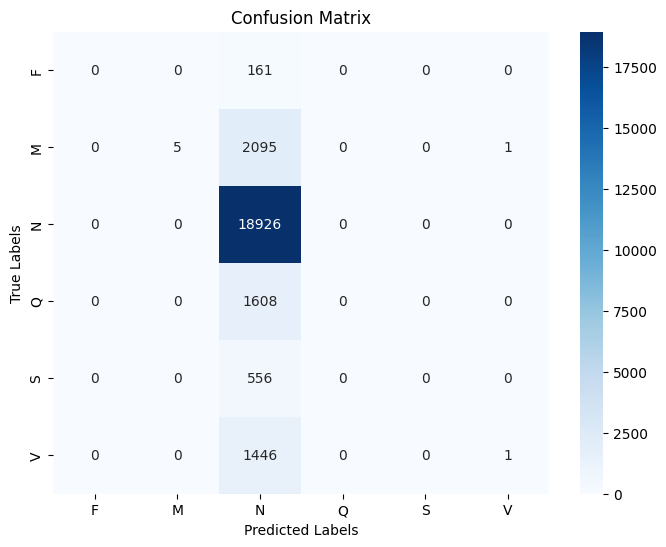

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and model predictions
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred = np.argmax(model.predict(test_dataset), axis=1)  # Predicted labels

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Found 99199 files belonging to 6 classes.
Class Distribution in Training Data:
F: 75709
M: 6431
N: 5789
Q: 8405
S: 642
V: 2223


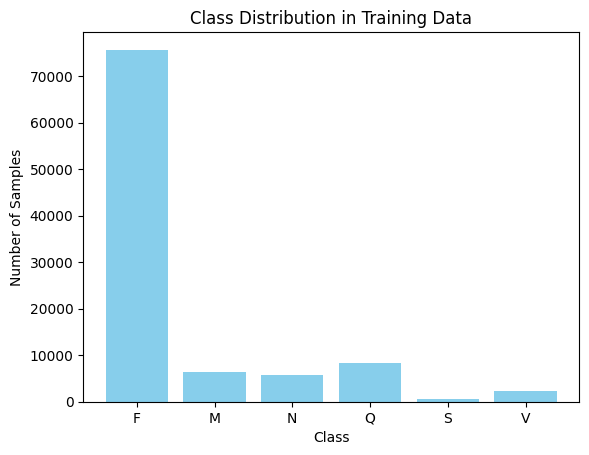

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset without transformations to analyze class distribution
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ECG_Image_data/train",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Count samples in each class
class_counts = Counter(label.numpy() for _, labels in train_dataset for label in labels)
class_names = train_dataset.class_names

# Print class distribution
print("Class Distribution in Training Data:")
for i, count in enumerate(class_counts.values()):
    print(f"{class_names[i]}: {count}")

# Plot class distribution
plt.bar(class_names, class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()


Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.
Class names: ['F', 'M', 'N', 'Q', 'S', 'V']
Class weights: {0: 25.733463035019454, 1: 1.9671326591314693, 2: 0.2183826443006208, 3: 2.5708454810495627, 4: 7.435075885328836, 5: 2.8555699481865284}
Epoch 1/10
2481/2481 [==============================] - 630s 253ms/step - loss: 0.1152 - accuracy: 0.9517 - val_loss: 0.2214 - val_accuracy: 0.9439
Epoch 2/10
2481/2481 [==============================] - 620s 250ms/step - loss: 0.0713 - accuracy: 0.9862 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 3/10
2481/2481 [==============================] - 625s 252ms/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 4/10
2481/2481 [==============================] - 623s 251ms/step - loss: 0.0154 - accuracy: 0.9979 - val_loss: 8.8252e-04 - val_accuracy: 0.9997
Epoch 5/10
2481/2481 [==============================] - 627s 253ms/step - loss

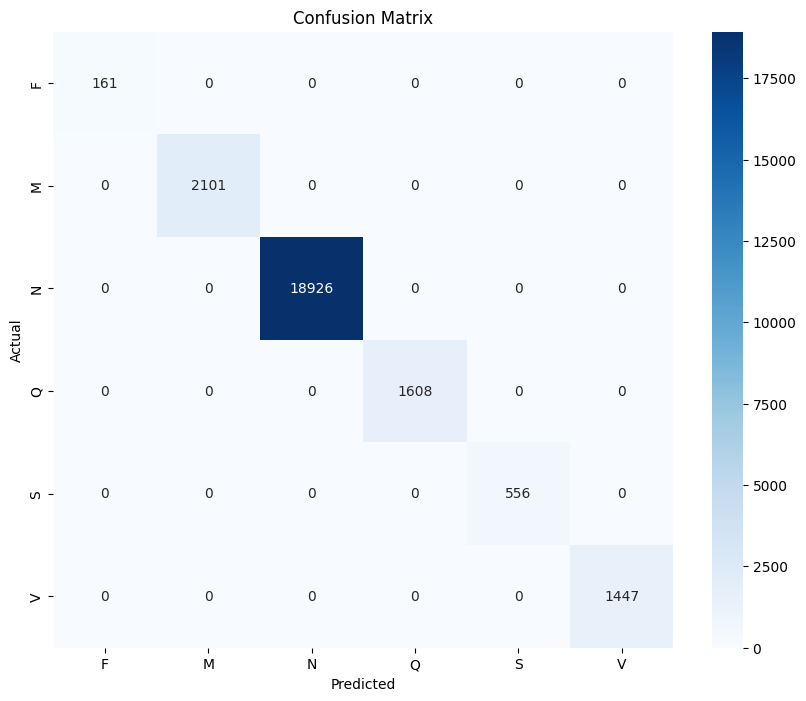

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os

# Define paths
train_dir = '/content/ECG_Image_data/train'
test_dir = '/content/ECG_Image_data/test'

# ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use part of train data as validation
)

# Set up the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Set up the test generator without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Display class distribution and calculate class weights
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
class_weight_dict = dict(zip(np.unique(class_counts), class_weights))

# Print class names and class weights for reference
print(f"Class names: {class_labels}")
print(f"Class weights: {class_weight_dict}")

# Model Architecture (Example CNN)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint('/content/drive/MyDrive/saved_models/model2.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model with class weights
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=[checkpoint]
)

# Load best model and evaluate on the test set
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/model2.keras')
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions and true labels for test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


# Define paths
train_dir = '/content/ECG_Image_data/train'
test_dir = '/content/ECG_Image_data/test'

# ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use part of train data as validation
)

# Set up the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Set up the test generator without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Display class distribution and calculate class weights
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
class_weight_dict = dict(zip(np.unique(class_counts), class_weights))

print(f"Class names: {class_labels}")
print(f"Class weights: {class_weight_dict}")

# Model Architecture with Regularization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),

    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Save the best model and use early stopping
checkpoint = ModelCheckpoint('/content/drive/MyDrive/saved_models/model3.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights and early stopping
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping]
)

# Load the best saved model and evaluate on the test set
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/model3.keras')
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the final model to Google Drive after evaluation
model.save('/content/drive/MyDrive/saved_models/model3.keras')

# Classification Report and Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.
Class names: ['F', 'M', 'N', 'Q', 'S', 'V']
Class weights: {0: 25.733463035019454, 1: 1.9671326591314693, 2: 0.2183826443006208, 3: 2.5708454810495627, 4: 7.435075885328836, 5: 2.8555699481865284}
Epoch 1/10
2481/2481 [==============================] - 643s 259ms/step - loss: 1.1780 - accuracy: 0.4897 - val_loss: 0.1421 - val_accuracy: 0.9994
Epoch 2/10
2481/2481 [==============================] - 640s 258ms/step - loss: 0.1308 - accuracy: 0.9944 - val_loss: 0.0705 - val_accuracy: 0.9998
Epoch 3/10
2481/2481 [==============================] - 636s 256ms/step - loss: 0.1020 - accuracy: 0.9937 - val_loss: 0.0844 - val_accuracy: 0.9997
Epoch 4/10
2481/2481 [==============================] - 640s 258ms/step - loss: 0.0658 - accuracy: 0.9977 - val_loss: 0.0570 - val_accuracy: 0.9997
Epoch 5/10
2481/2481 [==============================] - 635s 256ms/step - loss: 0.

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os

# Define paths for training and testing directories
train_dir = '/content/ECG_Image_data/train'
test_dir = '/content/ECG_Image_data/test'

# ImageDataGenerator with data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use part of the training data for validation
)

# Data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Calculate class weights based on the imbalance
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
class_weight_dict = dict(zip(np.unique(class_counts), class_weights))

# Print class names and weights for reference
print(f"Class names: {class_labels}")
print(f"Class weights: {class_weight_dict}")

# Load the VGG16 base model with pretrained weights and exclude the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_base.trainable = False  # Freeze the base model layers

# Build the model architecture
model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for model checkpointing, early stopping, and learning rate reduction
checkpoint = ModelCheckpoint('/content/drive/MyDrive/saved_models/vgg_model.keras',
                             save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
EPOCHS = 10  # Set a higher epoch count to allow for early stopping
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,  # Apply calculated class weights
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Load the best saved model for evaluation
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/vgg_model.keras')
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions and true labels for the test set
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Generate and plot the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.
Class names: ['F', 'M', 'N', 'Q', 'S', 'V']
Class weights: {0: 25.733463035019454, 1: 1.9671326591314693, 2: 0.2183826443006208, 3: 2.5708454810495627, 4: 7.435075885328836, 5: 2.8555699481865284}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2481/2481 ━━━━━━━━━━━━━━━━━━━━ 575s 226ms/step - accuracy: 0.7570 - loss: 1.3914 - val_accuracy: 0.9891 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 2/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 550s 221ms/step - accuracy: 0.9448 - loss: 0.7537 - val_accuracy: 0.9903 - val_loss: 0.5633 - learning_rate: 0.0010
Epoch 3/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 552s 222ms/step - accuracy: 0.9490 - loss: 0.6659 - val_accuracy: 0.9718 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 4/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 553s 222ms/step - accuracy: 0.9556 - loss: 0.5349 - val_accuracy: 0.9959 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 5/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 546s 220ms/step - accuracy: 0.9529 - loss: 0.5319 - val_accuracy: 0.9948 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 6/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 542s 218ms/step - accuracy: 0.9582 - loss: 0.4800 - val_accuracy: 0.9612 - val_loss: 0.4047 - learning_rate: 0.0010
Epoch 7/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 539s 217ms/step - acc